In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [12]:
housing_data = pd.read_csv('../data/housing_price.csv')
housing_data.shape

(1460, 81)

### We have changed the sampling strategy from Stratified to Random sampling as the model is Overfiting the TRAIN set. Lets have a look at Random sample one first and then look at Stratified one.

In [13]:
#from sklearn.model_selection import StratifiedShuffleSplit
#split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=42)
#for train_index, test_index in split.split(housing_data, housing_data['MSSubClass']):
#    housing_train_set = housing_data.loc[train_index]
#    housing_test_set = housing_data.loc[test_index]

In [14]:
# 80% of housing_data.shape[0] = 1168
max_index = housing_data.shape[0] - 1
numbers = max_index*80//100
train_indexs = np.linspace(start=0, stop=max_index, num=numbers, dtype=int)
test_indexs = [x for x in range(max_index) if x not in train_indexs]
print(len(train_indexs))
print(len(test_indexs))
housing_train_set = housing_data.loc[train_indexs]
housing_test_set = housing_data.loc[test_indexs]    

1167
293


In [15]:
housing_train_set.shape

(1167, 81)

In [16]:
def getMissingDataFeatures(df):
    ser_null_columns = df.isnull().any(axis=0)
    lst_null_columns = [x for x in ser_null_columns.index if ser_null_columns[x]]
    return lst_null_columns

def getNullPercentage(df, feature):
    null_count = len(df[df[feature].isnull()])
    percent_of_nulls = null_count*100/len(df)
    return null_count, percent_of_nulls

def dropFeaturesWithNulls(df, lst_featrues, threshold=75):
    for feature in lst_featrues:
        null_count, percent_of_nulls = getNullPercentage(df, feature)
#        print('Null count in {0} : {1}, Percent of Null: {2}'.format(feature, null_count, percent_of_nulls))
        if(percent_of_nulls > threshold):
#            print('Droping --- {}'.format(feature))
            df.drop(feature, axis=1, inplace=True)
    return df

def getCatFeatures(df):
    cat_features = df.select_dtypes(include=['object']).columns
    return cat_features

def getCatFeaturesWithNulls(df):
    ser_null_columns = df[getCatFeatures(df)].isnull().any(axis=0)
    lst_null_columns = [x for x in ser_null_columns.index if ser_null_columns[x]]
    return lst_null_columns

In [17]:
def fillNAwithBlank(df, lst_features):
    for feature in lst_features:
        df[feature].fillna('', inplace=True)
    return df

In [18]:
def formatCondition(lst_features):
    copy_lst_features = lst_features.copy()
    for i, v in enumerate(lst_features):
        if(i == 0):
            copy_lst_features.insert(i*2, 'not ')
        else:    
            copy_lst_features.insert(i*2, ' and not ')
                      
    #print(lst_features)
    return ''.join(copy_lst_features)

def conditionBasedImputation(row, condition, lst_features):
    if condition:
        for feature in lst_features:
            row[feature] = 'NA'
    return row

In [19]:
class FillNAandCleanUp(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X.fillna(value=X.mean()[['LotFrontage']], inplace=True)
        X['MasVnrArea'].fillna(value=0, inplace=True)
        
        #interpolation, we have to reindex the dataframe. Then interpolate, then drop(reset) the index.
        X.index = X['YearBuilt']
        X['GarageYrBlt'] = X['GarageYrBlt'].interpolate()
        X.reset_index(drop=True, inplace=True)

        X.rename(columns={'1stFlrSF':'FstFlrSF', '2ndFlrSF':'SecndFlrSF', '3SsnPorch':'ThreeSsnPorch'}, inplace=True)
        X.BsmtCond.fillna('TA', inplace=True)

        # Droping inconsistent data from the data frame.
        X.drop(X[X['GarageYrBlt'] < X['YearBuilt']].index, inplace=True)

        X.drop('MasVnrArea', axis=1, inplace=True)
        X.drop('MasVnrType', axis=1, inplace=True)
        X = dropFeaturesWithNulls(X, getCatFeaturesWithNulls(X))
        
        lst_featurs = ['BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
        X = fillNAwithBlank(X, lst_featurs)
        
        lst_features_bsmt = ['BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
        condition_bsmt = formatCondition(lst_features_bsmt)
        X = X.apply(lambda row: conditionBasedImputation(row, condition_bsmt, lst_features_bsmt), axis=1)
        
        lst_features_garag = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
        condition_garag = formatCondition(lst_features_garag)
        X = X.apply(lambda row: conditionBasedImputation(row, condition_garag, lst_features_garag), axis=1)

        X.drop(X[X.Electrical.isnull()].index, inplace=True)
        X.drop('FireplaceQu', axis = 1, inplace = True)
        return X

In [20]:
fillna_cleanup_pipeline = Pipeline([
         ('fillNAandCleanUp', FillNAandCleanUp())
      ])

In [21]:
housing_train_set = fillna_cleanup_pipeline.fit_transform(housing_train_set)

In [22]:
class CatFeatureCleanUpAndEncode(BaseEstimator, TransformerMixin):
    def __init__(self, lst_categories, feature, replace_val = None, lblEncode= None):
        self.lst_categories = lst_categories
        self.feature = feature
        if replace_val:
            self.replace_val = replace_val
        else:
            self.replace_val = 'OO_TH_ER'
            
        if lblEncode == None:
            self.lblEncode = True
        else:
            self.lblEncode = False
            
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        ser_non_cat_values = X[~ X[self.feature].isin(self.lst_categories)][self.feature]
        if(ser_non_cat_values.shape[0] > 0):
            X.loc[X[~ X[self.feature].isin(self.lst_categories)].index, self.feature] = self.replace_val
        
        # Convert to categorical feature
        X[self.feature] = pd.Categorical(X[self.feature], categories=self.lst_categories)
        
        if self.lblEncode:
            # Do label encoding
            X[self.feature] = X[self.feature].cat.codes
        else:
            # Do One-Hot encoding
            X = pd.get_dummies(X, columns=[self.feature], prefix=[self.feature], drop_first=True)
        return X

In [23]:
lst_MSZoning_cat = ['A','C','FV','I','RH','RL','RP','RM']
lst_Street_cat = ['Grvl','Pave']
lst_LotShape_cat = ['Reg','IR1','IR2','IR3']
lst_LandContour_cat = ['Lvl','Bnk','HLS','Low']
lst_Utilities_cat = ['AllPub','NoSewr','NoSeWa','ELO']
lst_LandSlope_cat = ['Gtl','Mod','Sev']
lst_Condition1_cat = ['Artery','Feedr','Norm','RRNn','RRAn','PosN','PosA','RRNe','RRAe']
lst_Condition2_cat = ['Artery','Feedr','Norm','RRNn','RRAn','PosN','PosA','RRNe','RRAe']
lst_BldgType_cat = ['1Fam','2FmCon','Duplx','TwnhsE','TwnhsI']
lst_HouseStyle_cat = ['1Story','1.5Fin','1.5Unf','2Story','2.5Fin','2.5Unf','SFoyer','SLvl']
lst_RoofStyle_cat = ['Flat','Gable','Gambrel','Hip','Mansard','Shed']
lst_RoofMatl_cat = ['ClyTile','CompShg','Membran','Metal','Roll','Tar&Grv','WdShake','WdShngl']
lst_Exterior1st_cat = ['AsbShng','AsphShn','BrkComm','BrkFace','CBlock','CemntBd','HdBoard','ImStucc','MetalSd','Other','Plywood',\
                       'PreCast','Stone','Stucco','VinylSd','Wd Sdng','WdShing']
lst_Exterior2nd_cat = ['AsbShng','AsphShn','BrkComm','BrkFace','CBlock','CemntBd','HdBoard','ImStucc','MetalSd','Other','Plywood',\
                       'PreCast','Stone','Stucco','VinylSd','Wd Sdng','WdShing']
lst_ExterQual_cat = ['Ex','Gd','TA','Fa','Po']
lst_ExterCond_cat = ['Ex','Gd','TA','Fa','Po']
lst_Foundation_cat = ['BrkTil','CBlock','PConc','Slab','Stone','Wood']
lst_BsmtQual_cat = ['Ex','Gd','TA','Fa','Po','NA']
lst_BsmtCond_cat = ['Ex','Gd','TA','Fa','Po','NA']
lst_BsmtExposure_cat = ['Gd','Av','Mn','No','NA'] 
lst_BsmtFinType1_cat = ['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA']
lst_BsmtFinType2_cat = ['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA']
lst_Heating_cat = ['Floor','GasA','GasW','Grav','OthW','Wall']
lst_HeatingQC_cat = ['Ex','Gd','TA','Fa','Po']
lst_CentralAir_cat = ['N','Y']
lst_Electrical_cat = ['SBrkr','FuseA','FuseF','FuseP','Mix']
lst_KitchenQual_cat = ['SBrkr','FuseA','FuseF','FuseP','Mix']
lst_KitchenQual_cat = ['Ex','Gd','TA','Fa','Po']
lst_Functional_cat = ['Typ','Min1','Min2','Mod','Maj1','Maj2','Sev','Sal']
lst_GarageType_cat = ['2Types','Attchd','Basment','BuiltIn','CarPort','Detchd','NA']
lst_GarageFinish_cat = ['Fin','RFn','Unf','NA']
lst_GarageQual_cat = ['Ex','Gd','TA','Fa','Po','NA']
lst_GarageCond_cat = ['Ex','Gd','TA','Fa','Po','NA']
lst_PavedDrive_cat = ['Y','P','N']
lst_SaleType_cat = ['WD ','CWD','VWD','New','COD','Con','ConLw','ConLI','ConLD','Oth']
lst_SaleCondition_cat = ['Normal','Abnorml','AdjLand','Alloca','Family','Partial']
                      
                      
                      
lst_LotConfig_cat = ['Inside','Corner','CulDSac','FR2','FR3']
lst_Neighborhood_cat = ['Blmngtn','Blueste','BrDale','BrkSide','ClearCr','CollgCr','Crawfor',\
                        'Edwards','Gilbert','IDOTRR','MeadowV','Mitchel','Names','NoRidge',\
                        'NPkVill','NridgHt','NWAmes','OldTown','SWISU','Sawyer','SawyerW',\
                        'Somerst','StoneBr','Timber','Veenker']

In [24]:
cat_feature_encod_pipeline = Pipeline([
        ('lst_MSZoning_cat', CatFeatureCleanUpAndEncode(lst_MSZoning_cat, 'MSZoning', 'C')),
        ('lst_Street_cat', CatFeatureCleanUpAndEncode(lst_Street_cat, 'Street')),
        ('lst_LotShape_cat', CatFeatureCleanUpAndEncode(lst_LotShape_cat, 'LotShape')),
        ('lst_LandContour_cat', CatFeatureCleanUpAndEncode(lst_LandContour_cat, 'LandContour')),
        ('lst_Utilities_cat', CatFeatureCleanUpAndEncode(lst_Utilities_cat, 'Utilities')),
        ('lst_LandSlope_cat', CatFeatureCleanUpAndEncode(lst_LandSlope_cat, 'LandSlope')),
        ('lst_Condition1_cat', CatFeatureCleanUpAndEncode(lst_Condition1_cat, 'Condition1')),    
        ('lst_Condition2_cat', CatFeatureCleanUpAndEncode(lst_Condition2_cat, 'Condition2')),
        ('lst_BldgType_cat', CatFeatureCleanUpAndEncode(lst_BldgType_cat, 'BldgType')),    
        ('lst_HouseStyle_cat', CatFeatureCleanUpAndEncode(lst_HouseStyle_cat, 'HouseStyle')),
        ('lst_RoofStyle_cat', CatFeatureCleanUpAndEncode(lst_RoofStyle_cat, 'RoofStyle')),
        ('lst_RoofMatl_cat', CatFeatureCleanUpAndEncode(lst_RoofMatl_cat, 'RoofMatl')),
        ('lst_Exterior1st_cat', CatFeatureCleanUpAndEncode(lst_Exterior1st_cat, 'Exterior1st')),    
        ('lst_Exterior2nd_cat', CatFeatureCleanUpAndEncode(lst_Exterior2nd_cat, 'Exterior2nd')),
        ('lst_ExterQual_cat', CatFeatureCleanUpAndEncode(lst_ExterQual_cat, 'ExterQual')), 
        ('lst_ExterCond_cat', CatFeatureCleanUpAndEncode(lst_ExterCond_cat, 'ExterCond')),
        ('lst_Foundation_cat', CatFeatureCleanUpAndEncode(lst_Foundation_cat, 'Foundation')),
        ('lst_BsmtQual_cat', CatFeatureCleanUpAndEncode(lst_BsmtQual_cat, 'BsmtQual')),
        ('lst_BsmtCond_cat', CatFeatureCleanUpAndEncode(lst_BsmtCond_cat, 'BsmtCond')),    
        ('lst_BsmtExposure_cat', CatFeatureCleanUpAndEncode(lst_BsmtExposure_cat, 'BsmtExposure')),
        ('lst_BsmtFinType1_cat', CatFeatureCleanUpAndEncode(lst_BsmtFinType1_cat, 'BsmtFinType1')), 
        ('lst_BsmtFinType2_cat', CatFeatureCleanUpAndEncode(lst_BsmtFinType2_cat, 'BsmtFinType2')),
        ('lst_Heating_cat', CatFeatureCleanUpAndEncode(lst_Heating_cat, 'Heating')),
        ('lst_HeatingQC_cat', CatFeatureCleanUpAndEncode(lst_HeatingQC_cat, 'HeatingQC')),
        ('lst_CentralAir_cat', CatFeatureCleanUpAndEncode(lst_CentralAir_cat, 'CentralAir')),
        ('lst_Electrical_cat', CatFeatureCleanUpAndEncode(lst_Electrical_cat, 'Electrical')),    
        ('lst_KitchenQual_cat', CatFeatureCleanUpAndEncode(lst_KitchenQual_cat, 'KitchenQual')),
        ('lst_Functional_cat', CatFeatureCleanUpAndEncode(lst_Functional_cat, 'Functional')), 
        ('lst_GarageType_cat', CatFeatureCleanUpAndEncode(lst_GarageType_cat, 'GarageType')),
        ('lst_GarageFinish_cat', CatFeatureCleanUpAndEncode(lst_GarageFinish_cat, 'GarageFinish')),
        ('lst_GarageQual_cat', CatFeatureCleanUpAndEncode(lst_GarageQual_cat, 'GarageQual')),
        ('lst_GarageCond_cat', CatFeatureCleanUpAndEncode(lst_GarageCond_cat, 'GarageCond')),    
        ('lst_PavedDrive_cat', CatFeatureCleanUpAndEncode(lst_PavedDrive_cat, 'PavedDrive')),
        ('lst_SaleType_cat', CatFeatureCleanUpAndEncode(lst_SaleType_cat, 'SaleType')), 
        ('lst_SaleCondition_cat', CatFeatureCleanUpAndEncode(lst_SaleCondition_cat, 'SaleCondition')),
    
        ('lst_LotConfig_cat', CatFeatureCleanUpAndEncode(lst_LotConfig_cat, 'LotConfig', lblEncode= False)),
        ('lst_Neighborhood_cat', CatFeatureCleanUpAndEncode(lst_Neighborhood_cat, 'Neighborhood', lblEncode=False))
      ]) 

In [25]:
housing_train_set = cat_feature_encod_pipeline.transform(housing_train_set)

In [26]:
housing_train_set.shape

(1149, 100)

In [17]:
# y = housing_data.SalePrice
# X = housing_data.drop('SalePrice', axis=1)
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)

In [27]:
y_train = housing_train_set['SalePrice'].values
print('y_train - type : ', type(y_train))
print('y_train - shape : ', y_train.shape)
print('y_train - array : ', y_train)

y_train - type :  <class 'numpy.ndarray'>
y_train - shape :  (1149,)
y_train - array :  [208500 181500 223500 ..., 210000 266500 147500]


In [28]:
X_features  = [feature for feature in housing_train_set.columns if feature not in ['SalePrice', 'Id']]
print(X_features)

['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'FstFlrSF', 'SecndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'LotConfig_Corner', 'LotConfi

In [29]:
X_train = housing_train_set[X_features].values
print('X_train - type : ', type(X_train))
print('X_train - shape : ', X_train.shape)
print('X_train - array : ', X_train)

X_train - type :  <class 'numpy.ndarray'>
X_train - shape :  (1149, 98)
X_train - array :  [[ 60.   5.  65. ...,   0.   0.   0.]
 [ 20.   5.  80. ...,   0.   0.   1.]
 [ 60.   5.  68. ...,   0.   0.   0.]
 ..., 
 [ 20.   5.  85. ...,   0.   0.   0.]
 [ 70.   5.  66. ...,   0.   0.   0.]
 [ 20.   5.  75. ...,   0.   0.   0.]]


In [21]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)

In [48]:
X_train.shape

(1149, 98)

In [30]:
from sklearn.linear_model import LinearRegression
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)
print('Linear Model Coefficients : ', lm_model.coef_)
print('Linear Model Intercept : ', lm_model.intercept_)

Linear Model Coefficients :  [ -2.14970784e+02   1.85424491e+03  -6.69955830e+01   3.19861537e-01
   1.39747537e+04  -3.65963195e+03   1.60514427e+03  -4.17977998e+04
   1.98077015e+03  -1.28055588e+03  -1.00530007e+04  -2.74212835e+03
   5.25034788e+02   1.08562090e+04   4.66491537e+03   7.27297744e+01
   4.31358827e+01   3.91935482e+03   8.46308484e+03  -7.80543304e+02
   3.09361787e+02  -5.70152324e+03   2.97143282e+03   7.76978275e+02
  -7.50333129e-11   2.27038596e+03   2.11002771e-10  -7.45330908e-10
   7.36259888e+00  -3.72892828e-10   3.35567344e+00  -3.03088267e+00
   7.68738958e+00   3.80212816e+02  -1.82777425e+03  -2.61356498e+03
   2.51821065e+03   1.47467419e+01   1.39043299e+01  -5.22602017e+00
   2.34250516e+01   8.32247266e+03   1.14847021e+04   1.04307608e+04
   1.86362047e+03  -5.31609877e+03  -1.41256215e+04  -8.19546916e+03
   4.26603196e+03  -4.81028732e+03   5.49512921e+03   1.09139364e-10
   1.45362279e+02  -1.86446414e-11   1.39537082e+04  -1.89949511e+01
   4.

### Check accuracy on TRAIN set

In [34]:
from sklearn.metrics import mean_squared_error, r2_score
pred_X_train = lm_model.predict(X_train)
mse_X_train =  mean_squared_error(y_train, pred_X_train)
r2_X_train = r2_score(y_train, pred_X_train)
print('Root Mean Squared Error X Train : ', np.sqrt(mse_X_train))
print('R-Squre X Train : ', r2_X_train)

Root Mean Squared Error X Train :  30697.0300456
R-Squre X Train :  0.860373949795


### Apply transformation on TEST set using PIPELINES

In [35]:
housing_test_set = fillna_cleanup_pipeline.transform(housing_test_set)
housing_test_set = cat_feature_encod_pipeline.transform(housing_test_set)

In [36]:
housing_test_set.shape

(288, 100)

In [38]:
y_test = housing_test_set['SalePrice'].values
X_test = housing_test_set[X_features].values

In [39]:
pred_X_test = lm_model.predict(X_test)
mse_X_test =  mean_squared_error(y_test, pred_X_test)
r2_X_test = r2_score(y_test, pred_X_test)
print('Root Mean Squared Error X TEST : ', np.sqrt(mse_X_test))
print('R-Squre X TEST : ', r2_X_test)

Root Mean Squared Error X TEST :  26240.2389345
R-Squre X TEST :  0.850823709381


# Save Model for Future Use 

In [40]:
import pickle
filename = '../models/lm_model_housing_data.sav'
pickle.dump(lm_model, open(filename, 'wb'))

# Linear Algebric Way of solving an equation.

<a href="./NormalEquation/Normal Equation.html"> Normal Equation</a> is the linear algibric way of solving a linear equation.

In [41]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

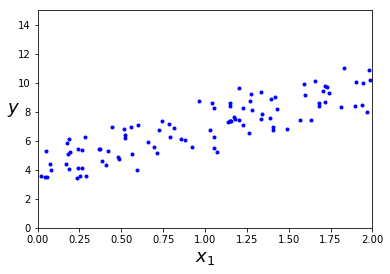

In [43]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

In [45]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [46]:
theta_best

array([[ 4.1415861 ],
       [ 2.86654992]])

In [47]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([ 4.1415861]), array([[ 2.86654992]]))